Solve time:  1.8147635459899902


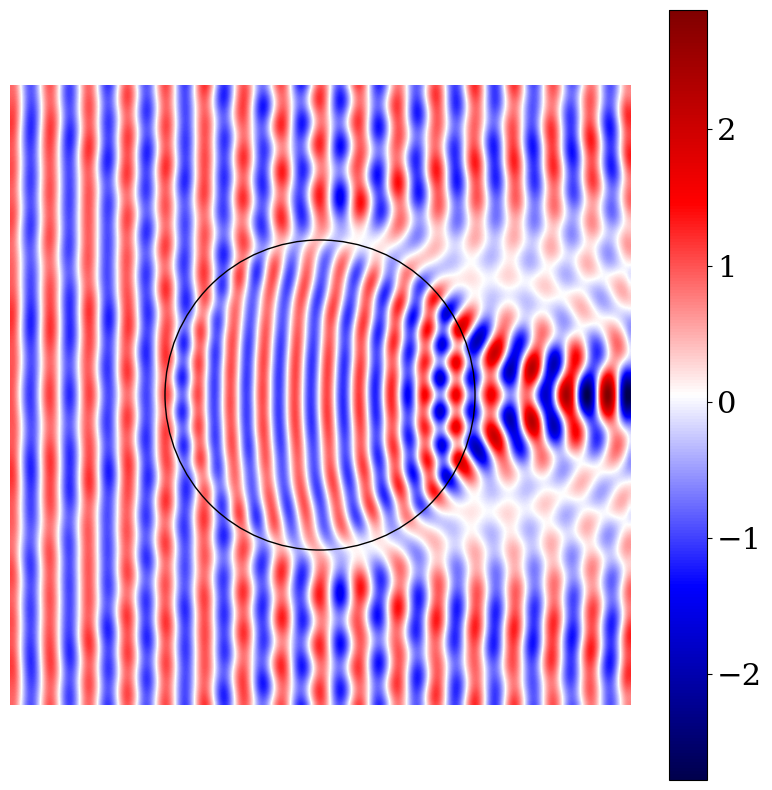

In [ ]:
#
# Scattering of a plane wave by a penetrable circle
# =================================================
#
# This demo illustrates how to:
#
# * Compute the scattering of a plane wave by a homogeneous dielectric obstable
# * Employ an "adiabatic layer" to truncate the domain
# * Evaluate the FEM solution at specified grid points
# * Make a nice plot of the solution in the domain
# * Compare the approximation to the analytical solution
#
# Adiabatic absorbers are presented in detail in
# "The failure of perfectly matched layers, and towards their redemption
#  by adiabatic absorbers" - Oskooi et al. (2008)

import time
import numpy as np
import matplotlib.pyplot as plt
import dolfinx

from dolfinx import fem, mesh, io, geometry
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
from ufl import (dx, grad, inner, TestFunction, TrialFunction)
from mpi4py import MPI
from petsc4py import PETSc

# from analytical import penetrable_circle

# This implementation relies on the complex mode of dolfin-x, invoked by
# executing the command:
# source /usr/local/bin/dolfinx-complex-mode
if not np.issubdtype(PETSc.ScalarType, np.complexfloating):
    print('This demo only works with PETSc-complex')
    exit()


'''                        Problem parameters                               '''
k0 = 10                  # wavenumber
wave_len = 2*np.pi / k0  # wavelength
radius = 4 * wave_len    # scatterer radius
ref_ind = 1.2            # refractive index of scatterer
dim_x = 20*wave_len      # width of computational domain

'''    Discretization parameters: polynomial degree and mesh resolution     '''
degree = 3  # polynomial degree
n_wave = 5  # number of mesh elements per wavelength

'''                   Adiabatic absorber settings                           '''
# The adiabatic absorber is a PML-type layer in which absorption is used to
# attenutate outgoing waves. Adiabatic absorbers aren't as perfect as PMLs so
# must be slightly wider: typically 2-5 wavelengths gives adequately small
# reflections.
d_absorb = 2 * wave_len    # depth of absorber

# Increase the absorption within the layer gradually, as a monomial:
# sigma(x) = sigma_0 * x^d; choices d=2,3 are popular choices.
deg_absorb = 2    # degree of absorption monomial

# The constant sigma_0 is chosen to achieve a specified "round-trip" reflection
# of a wave that through the layer, reflects and returns back into the domain.
# See Oskooi et al. (2008) for more details.
RT = 1.0e-6       # round-trip reflection
sigma0 = -(deg_absorb + 1) * np.log(RT) / (2.0 * d_absorb)

'''                             Meshing                                     '''
# For this problem we use a square mesh with triangular elements.
# The mesh element size is h_elem, and the #elements in one dimension is n_elem
h_elem = wave_len / n_wave
n_elem = int(np.round(dim_x/h_elem))

# Create mesh
mesh = mesh.create_rectangle(MPI.COMM_WORLD,
                     [np.array([-dim_x/2, -dim_x/2]),
                      np.array([dim_x/2, dim_x/2])],
                     [n_elem, n_elem],
                     mesh.CellType.triangle,
                     ghost_mode=mesh.GhostMode.none)

'''        Incident field, wavenumber and adiabatic absorber functions      '''


def incident(x):
    # Plane wave travelling in positive x-direction
    return np.exp(1.0j * k0 * x[0])


def wavenumber(x):
    # Wavenumber function, k0 outside scatterer and (k0*ref_ind) inside.
    # This function also defines the shape as a circle. Modify for different
    # shapes.
    r = np.sqrt((x[0])**2 + (x[1])**2)
    inside = (r <= radius)
    outside = (r > radius)
    return inside * ref_ind * k0 + outside * k0


def adiabatic_layer(x):
    '''          Contribution to wavenumber k in absorbing layers          '''
    # In absorbing layer, have k = k0 + 1j * sigma
    # => k^2 = (k0 + 1j*sigma)^2 = k0^2 + 2j*sigma*k0 - sigma^2
    # Therefore, the 2j*sigma - sigma^2 piece must be included in the layer.

    # Find borders of width d_absorb in x- and y-directions
    in_absorber_x = (np.abs(x[0]) >= dim_x/2 - d_absorb)
    in_absorber_y = (np.abs(x[1]) >= dim_x/2 - d_absorb)

    # Function sigma_0 * x^d, where x is depth into adiabatic layer
    sigma_x = sigma0 * ((np.abs(x[0])-(dim_x/2-d_absorb))/d_absorb)**deg_absorb
    sigma_y = sigma0 * ((np.abs(x[1])-(dim_x/2-d_absorb))/d_absorb)**deg_absorb

    # 2j*sigma - sigma^2 in absorbing layers
    x_layers = in_absorber_x * (2j * sigma_x * k0 - sigma_x**2)
    y_layers = in_absorber_y * (2j * sigma_y * k0 - sigma_y**2)

    return x_layers + y_layers


# Define function space
V = fem.functionspace(mesh, ("Lagrange", degree))

# Interpolate wavenumber k onto V
k = fem.Function(V)
k.interpolate(wavenumber)

# Interpolate absorbing layer piece of wavenumber k_absorb onto V
k_absorb = fem.Function(V)
k_absorb.interpolate(adiabatic_layer)

# Interpolate incident wave field onto V
ui = fem.Function(V)
ui.interpolate(incident)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(u), grad(v)) * dx \
    - k**2 * inner(u, v) * dx \
    - k_absorb * inner(u, v) * dx

L = inner((k**2 - k0**2) * ui, v) * dx

problem = LinearProblem(a, L, petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "mumps"},)

# Solve linear system
start = time.time()
uh = problem.solve()
end = time.time()
time_elapsed = end - start
print('Solve time: ', time_elapsed)

# Square grid with 10 points per wavelength in each direction
Nx = int(np.ceil(dim_x/wave_len * 10))
Ny = Nx

# Grid does not include absorbing layers
dim_in = dim_x - 2 * d_absorb

# Grid points
xmin, xmax, ymin, ymax = [-dim_in/2, dim_in/2, -dim_in/2, dim_in/2]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))


# Bounding box tree for function evaluations
tree = geometry.bb_tree(mesh, mesh.topology.dim)
points_2d = points[:2, :]

cell_candidates = geometry.compute_collisions_points(tree, points.T)
colliding_cells = geometry.compute_colliding_cells(
            mesh, cell_candidates, points.T
        )

cells = []
points_on_proc = []

for i, point in enumerate(points.T):
            if len(colliding_cells.links(i)) > 0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])

# Evaluate scattered and incident fields at grid points
u_sca = uh.eval(points.T, cells).reshape((Nx, Ny))
inc_field = incident(points_2d)
u_inc = inc_field.reshape((Nx, Ny))

# Sum to give total field
u_total = u_inc + u_sca

'''                     Plot field and save figure                          '''
plt.rc('font', family='serif', size=22)
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(np.fliplr(np.real(u_total)).T,
           extent=[-dim_in/2, dim_in/2, -dim_in/2, dim_in/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16')
circle = plt.Circle((0., 0.), radius, color='black', fill=False)
ax.add_artist(circle)
plt.axis('off')
plt.colorbar()
plt.show()